### Simulation code for Linear Upper Confidence Bound (LinUCB) on sythetic dataset

- **Algorithm**: see LinUCB-disjoint in the main text.


- **Basline synthetic dataset**: equal utility across groups (0.9), unequal group size (9:1) on 4 features, 4 items.


- **Variation dataset**: change utility to 0.5, change group size ratio (8:2, 7:3, 6:4, 5:5).


- **Evaluation metrics**: prediction accuracy per group (see figures in the end).


- **Simulation setup**: we ran 100 simulations - each time with a new random dataset with parameters described above, with 1000 rounds of recommendations within each simulation.

In [1]:
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
import time
from collections import Counter
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
# ref: https://kfoofw.github.io/contextual-bandits-linear-ucb-disjoint/
'''
Environments
'''


# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():

    def __init__(self, arm_index, d, alpha):
        # Track arm index
        self.arm_index = arm_index

        # Keep track of alpha
        self.alpha = alpha

        # A: (d x d) matrix = D_a.T * D_a + I_d.
        # The inverse of A is used in ridge regression
        self.A = np.identity(d)

        # b: (d x 1) corresponding response vector.
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d, 1])

    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)

        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)

        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1, 1])

        # Find ucb based on p formulation (mean + std_dev)
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T, x) + self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv, x)))

        return p

    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1, 1])

        # Update A which is (d * d) matrix.
        self.A += np.dot(x, x.T)

        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x


class linucb_policy():

    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index=i, d=d, alpha=alpha) for i in range(K_arms)]

    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1

        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []

        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)

            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                # Set new max ucb
                highest_ucb = arm_ucb

                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_ucb == highest_ucb:
                candidate_arms.append(arm_index)

        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm = np.random.choice(candidate_arms)

        return chosen_arm


def ctr_simulator(K_arms, d, alpha, data_path):
    # Initiate policy
    linucb_policy_object = linucb_policy(K_arms=K_arms, d=d, alpha=alpha)

    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = []  # for unaligned time steps
    chosen_arm = []

    kept_line = []
    skipped_line = []

    # Open data
    with open(data_path, "r") as f:

        for line, line_data in enumerate(f):

            # 1st column: Logged data arm.
            # Integer data type
            data_arm = int(line_data.split()[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split()[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split()[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            arm_index = linucb_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if arm_index + 1 == data_arm:
                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards / aligned_time_steps)

                chosen_arm.append(arm_index)
                kept_line.append(line)

            else:
                skipped_line.append(line)

    return aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object, chosen_arm, kept_line, skipped_line

### Baseline.

In [4]:

'''
Simulations
'''

MINOR = []
MAJOR = []
DIFF = []
for sim in range(100): # times of simulations

    '''
    generate synthetic dataset
    '''
    
    rewards = 0.9 # utility equal across groups
    features = 0.9  # majority v. minority ratio
    rounds = 1000 # times of recommendations
    arms = 4 # types of movies

    data = []
    S = []
    U = []
    for i in range(arms):
        S.append(np.random.binomial(1, rewards, rounds))
        U.append(np.random.binomial(1, features, rounds))
        time.sleep(1)
    data = pd.DataFrame(list(zip(S[0], S[1], S[2], S[3], U[0], U[1], U[2], U[3])),
                        columns=['Arm1', 'Arm2', 'Arm3', 'Arm4', 'Context1', 'Context2', 'Context3', 'Context4'])

    # random pick one arm as the dataset for eval later; something like the news_dataset.txt.
    arm_list = [1, 2, 3, 4]
    data['picked'] = np.random.choice(arm_list, rounds)

    realized = []
    for row in range(len(data['picked'])):
        armindex = data['picked'][row]
        realized.append(data.iloc[row][armindex - 1])
    data['realized'] = realized

    # finalize and save to txt
    sim_dataset = data[['picked', 'realized', 'Context1', 'Context2', 'Context3', 'Context4']]
    np.savetxt('sim_dataset.txt', sim_dataset.values, fmt='%d', delimiter="\t")

   
    '''
    simulate recs on that dataset
    '''
    
    # set parameters
    alpha_input = 1.0  # the smaller the more exploit v. the bigger the more explore
    data_path = "sim_dataset.txt"
    aligned_time_steps, cum_rewards, aligned_ctr, policy, chosen_arm, kept_line, skipped_line = \
        ctr_simulator(K_arms=4, d=4, alpha=alpha_input, data_path=data_path)


    '''
    get prediction error by group
    '''
    
    for i in kept_line:
        data.loc[data.index[i], 'kept_or_skipped'] = 'kept'
    data['kept_or_skipped'] = data['kept_or_skipped'].fillna('skipped')

    minority_keep_rate = []
    majority_keep_rate = []
    diff = []
    context_list = ['Context1', 'Context2', 'Context3', 'Context4']
    for i in context_list:
        temp = data.groupby([i, 'kept_or_skipped']).count()
        minority_keep_rate.append(temp['Arm2'][0][0] / (temp['Arm2'][0][0] + temp['Arm2'][0][1]))
        majority_keep_rate.append(temp['Arm2'][1][0] / (temp['Arm2'][1][0] + temp['Arm2'][1][1]))
        diff_in_keep_rate = (temp['Arm2'][0][0] / (temp['Arm2'][0][0] + temp['Arm2'][0][1])) - (temp['Arm2'][1][0] / (
                temp['Arm2'][1][0] + temp['Arm2'][1][1]))
        diff.append(diff_in_keep_rate)
        
    MINOR.append(minority_keep_rate)
    MAJOR.append(majority_keep_rate)
    DIFF.append(diff)

    sim += 1
    time.sleep(0.1)

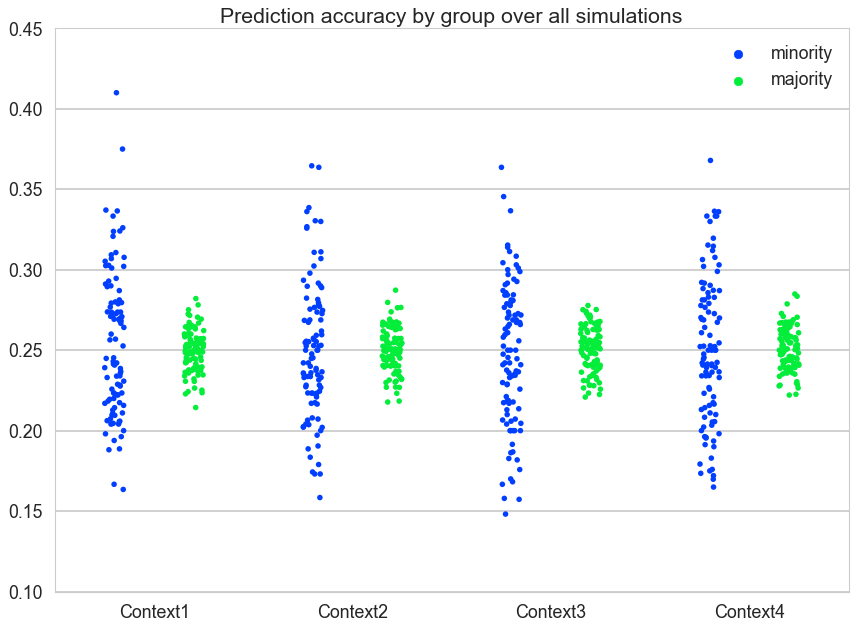

In [20]:

'''
Visualizations
'''

# variables for plot.
contexts = ['Context1', 'Context2', 'Context3', 'Context4'] * 2 * 100
populations = ['minority'] * 4 * 100 + ['majority'] * 4 * 100
keptrates = list(itertools.chain(*(MINOR + MAJOR)))
flat_diff = [item for sublist in DIFF for item in sublist]

# vis.
plt.style.use('seaborn-whitegrid')

# y-axis plots kept rate (i.e., accuracy rate) v.
# x-axis plots each feature (i.e., gender, race, age, ses) v.
# hue plots majority/minority population (i.e., if bad predictions for minority)
sns.stripplot(x=contexts, y=keptrates, hue=populations, jitter=True, dodge=True)
plt.title("Prediction accuracy by group over all simulations")
plt.show()

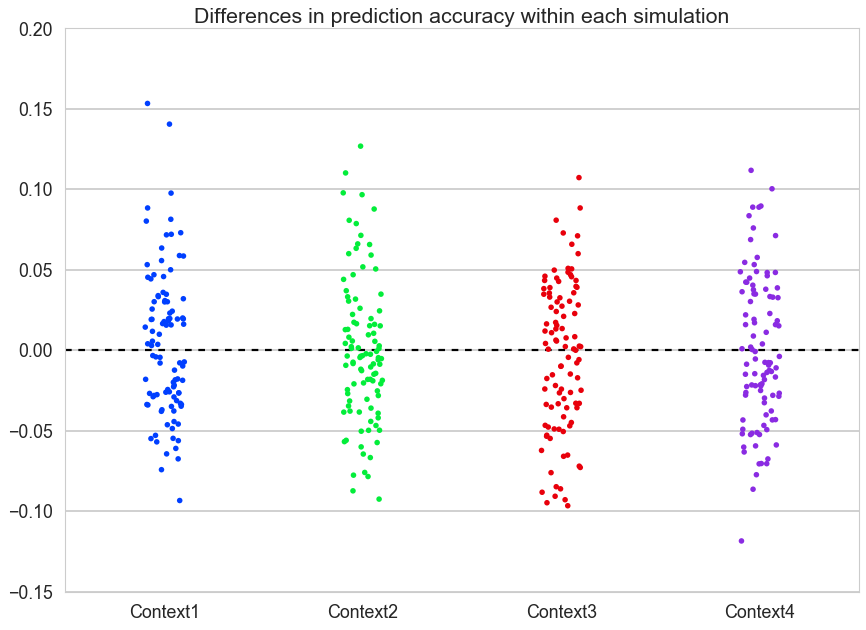

In [21]:
contexts = ['Context1', 'Context2', 'Context3', 'Context4'] * 100
ax = sns.stripplot(x=contexts, y=flat_diff, jitter=True, dodge=True)
ax.axhline(y=0, color='black', linestyle='dashed', linewidth=2)
plt.title("Differences in prediction accuracy within each simulation")
plt.show()

### Variations.

In [47]:
# rewards = 0.5 & group size = 8/2 v. 7/3 v. 6/4 v. 5/5

'''
Simulations
'''

MINOR = []
MAJOR = []
DIFF = []
for sim in range(100): # times of simulations

    '''
    generate synthetic dataset
    '''
    
    rewards = 0.5 # change here
    # group size vary by feature
    rounds = 1000
    arms = 4

    data = []
    S = []
    for i in range(arms):
        S.append(np.random.binomial(1, rewards, rounds))
        time.sleep(0.5)
    U[0] = np.random.binomial(1, 0.8, rounds)
    U[1] = np.random.binomial(1, 0.7, rounds)
    U[2] = np.random.binomial(1, 0.6, rounds)
    U[3] = np.random.binomial(1, 0.5, rounds)
    data = pd.DataFrame(list(zip(S[0], S[1], S[2], S[3], U[0], U[1], U[2], U[3])),
                        columns=['Arm1', 'Arm2', 'Arm3', 'Arm4', 'Context1', 'Context2', 'Context3', 'Context4'])

    # random pick one arm as the dataset for eval later; something like the news_dataset.txt.
    arm_list = [1, 2, 3, 4]
    data['picked'] = np.random.choice(arm_list, rounds)

    realized = []
    for row in range(len(data['picked'])):
        armindex = data['picked'][row]
        realized.append(data.iloc[row][armindex - 1])
    data['realized'] = realized

    # finalize and save to txt
    sim_dataset = data[['picked', 'realized', 'Context1', 'Context2', 'Context3', 'Context4']]
    np.savetxt('sim_dataset.txt', sim_dataset.values, fmt='%d', delimiter="\t")

   
    '''
    simulate recs on that dataset
    '''
    
    # set parameters
    alpha_input = 1.0  # the smaller the more exploit v. the bigger the more explore
    data_path = "sim_dataset.txt"
    aligned_time_steps, cum_rewards, aligned_ctr, policy, chosen_arm, kept_line, skipped_line = \
        ctr_simulator(K_arms=4, d=4, alpha=alpha_input, data_path=data_path)


    '''
    get prediction error by group
    '''
    
    for i in kept_line:
        data.loc[data.index[i], 'kept_or_skipped'] = 'kept'
    data['kept_or_skipped'] = data['kept_or_skipped'].fillna('skipped')

    minority_keep_rate = []
    majority_keep_rate = []
    diff = []
    context_list = ['Context1', 'Context2', 'Context3', 'Context4']
    for i in context_list:
        temp = data.groupby([i, 'kept_or_skipped']).count()
        minority_keep_rate.append(temp['Arm2'][0][0] / (temp['Arm2'][0][0] + temp['Arm2'][0][1]))
        majority_keep_rate.append(temp['Arm2'][1][0] / (temp['Arm2'][1][0] + temp['Arm2'][1][1]))
        diff_in_keep_rate = (temp['Arm2'][0][0] / (temp['Arm2'][0][0] + temp['Arm2'][0][1])) - (temp['Arm2'][1][0] / (
                temp['Arm2'][1][0] + temp['Arm2'][1][1]))
        diff.append(diff_in_keep_rate)
        
    MINOR.append(minority_keep_rate)
    MAJOR.append(majority_keep_rate)
    DIFF.append(diff)

    sim += 1
    time.sleep(1)

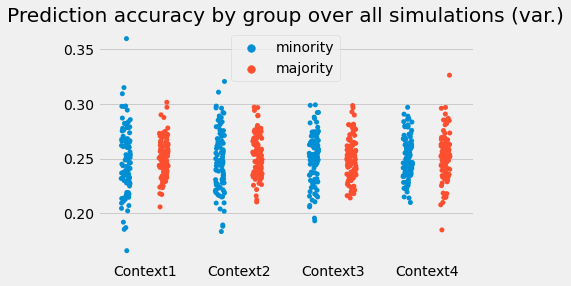

In [48]:

'''
Visualizations
'''

# variables for plot.
contexts = ['Context1', 'Context2', 'Context3', 'Context4'] * 2 * 100
populations = ['minority'] * 4 * 100 + ['majority'] * 4 * 100
keptrates = list(itertools.chain(*(MINOR + MAJOR)))
flat_diff = [item for sublist in DIFF for item in sublist]


# y-axis plots kept rate (i.e., accuracy rate) v.
# x-axis plots each feature (i.e., gender, race, age, ses) v.
# hue plots majority/minority population (i.e., if bad predictions for minority)
sns.stripplot(x=contexts, y=keptrates, hue=populations, jitter=True, dodge=True)
plt.title("Prediction accuracy by group over all simulations (var.)")
plt.show()

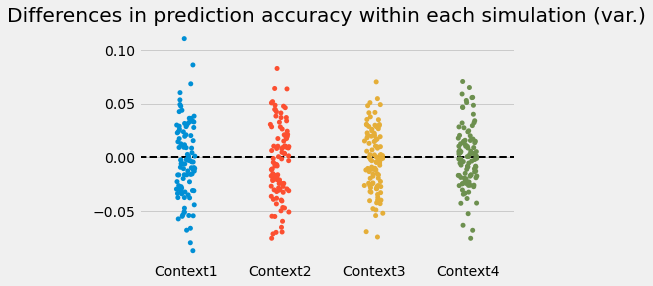

In [55]:
contexts = ['Context1', 'Context2', 'Context3', 'Context4'] * 100
ax = sns.stripplot(x=contexts, y=flat_diff, jitter=True, dodge=True)
ax.axhline(y=0, color='black', linestyle='dashed', linewidth=2)
plt.title("Differences in prediction accuracy within each simulation (var.)")
plt.show()